## RESEARCH QUESTION

Given the data for the first two years of operation and company’s revenue, can we predict the revenue for the following 60 days after January 1,2021? Can we find patterns so that stakeholders can understand the impact of churn on their revenue?


## SUMMARY OF ASSUMPTIONS

The assumptions of a time series model are: 

* Time series require stationary data. The mean, variance and autocorrelation remain constant over time. The origin of time will not affect statistical attributes of the process. 
* There is the assumption that residuals are independent. Therefore, there aren’t any significant autocorrelations of the residuals.
* We assume that the data has no outliers/anomalies in the series. 
* Error terms are distributed randomly meanwhile the mean and variance remain constant. 
* Random error components have a mean of zero. They are randomly distributed, and the variance is constant. 
* The historic timepoints might not dictate behavior in a stressed market.
* Stationarity should satisfy these three conditions - the mean and standard deviation are constant. Seasonality does not exist.


In [ ]:
#import packages
from matplotlib import pyplot as plt
import seaborn as sns, pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from collections import Counter
import statsmodels.api as sm 
from sklearn.decomposition import PCA
import statsmodels.stats.outliers_influence as inf
%matplotlib inline
import matplotlib.dates as mdates
from pylab import rcParams
from datetime import datetime
#import auto_arima module and run auto_arima
from pmdarima.arima import auto_arima
#import ARIMA from statsmodels.tsa.arima.model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

In [2]:
#import file and create dataset
df = pd.read_csv('timeseries.csv',dtype={'locationid':np.int64})

In [3]:
df.head()

,Day,Revenue
0,1,0.000000
1,2,0.000793
2,3,0.825542
3,4,0.320332
4,5,1.082554


In [5]:
#summary statistics
df.describe()

,Day,Revenue
count,731.000000,731.000000
mean,366.000000,9.822901
std,211.165812,3.852645
min,1.000000,0.000000
25%,183.500000,6.872836
50%,366.000000,10.785571
75%,548.500000,12.566911
max,731.000000,18.154769


In [6]:
#summarize null value findings
df.isnull().sum()

Day        0
Revenue    0
dtype: int64

## TIME STEP FORMATTING

In [7]:
# import datetime module
import datetime


dti = pd.date_range('2019-01-01', periods=731)
dti = dti.shift(1, freq='D')
   
df['Day'] = dti


#set index using day
df.set_index('Day', inplace=True)
df.index


DatetimeIndex(['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-05',
               '2019-01-06', '2019-01-07', '2019-01-08', '2019-01-09',
               '2019-01-10', '2019-01-11',
               ...
               '2020-12-23', '2020-12-24', '2020-12-25', '2020-12-26',
               '2020-12-27', '2020-12-28', '2020-12-29', '2020-12-30',
               '2020-12-31', '2021-01-01'],
              dtype='datetime64[ns]', name='Day', length=731, freq=None)

array([[<AxesSubplot:title={'center':'Revenue'}>]], dtype=object)

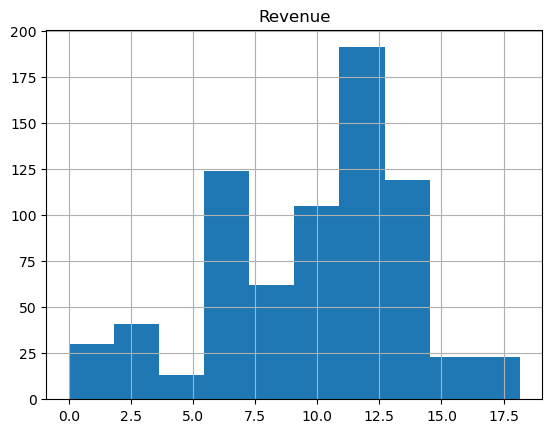

In [8]:
#create a histogram
df.hist()

## LINE GRAPH VISUALIZATION

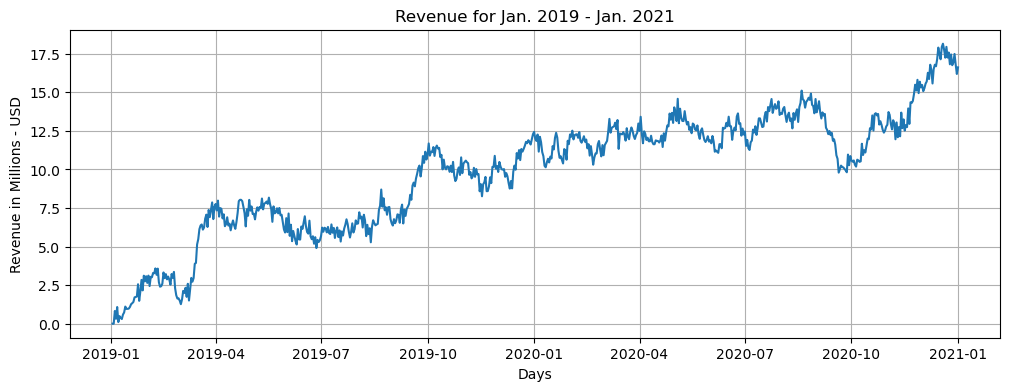

In [12]:
#visualization
plt.figure(figsize=(12,4))
plt.plot(df.Revenue)
plt.xlabel('Days')
plt.ylabel('Revenue in Millions - USD')
plt.title('Revenue for Jan. 2019 - Jan. 2021')
plt.grid(True)
plt.show()

## STATIONARITY
Stationarity is the joint distribution of the data, and this data is not dependent on time.
We will determine if this is evident using the Augmented Dick-Fuller (ADFuller) test.
This will test if the data is non-stationary. We will look for a p-value that is less than or
equal to 0.05 to accept or reject the null hypothesis.

Based on the results of the ADFuller test, the p-value is greater than 0.05. Therefore, we
have failed to reject the null hypothesis. The data is non-stationary.


In [9]:
#apply the adfuller test for stationarity
from statsmodels.tsa.stattools import adfuller
results = adfuller(df['Revenue'])

#print test statistic
print("Test statistic:",results[0])

#print p-value
print("The p-value is:", results[1])

#print the critical values
print("The critical values are:", results[4])



Test statistic: -1.924612157310184
The p-value is: 0.3205728150793963
The critical values are: {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


/Users/draihome/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


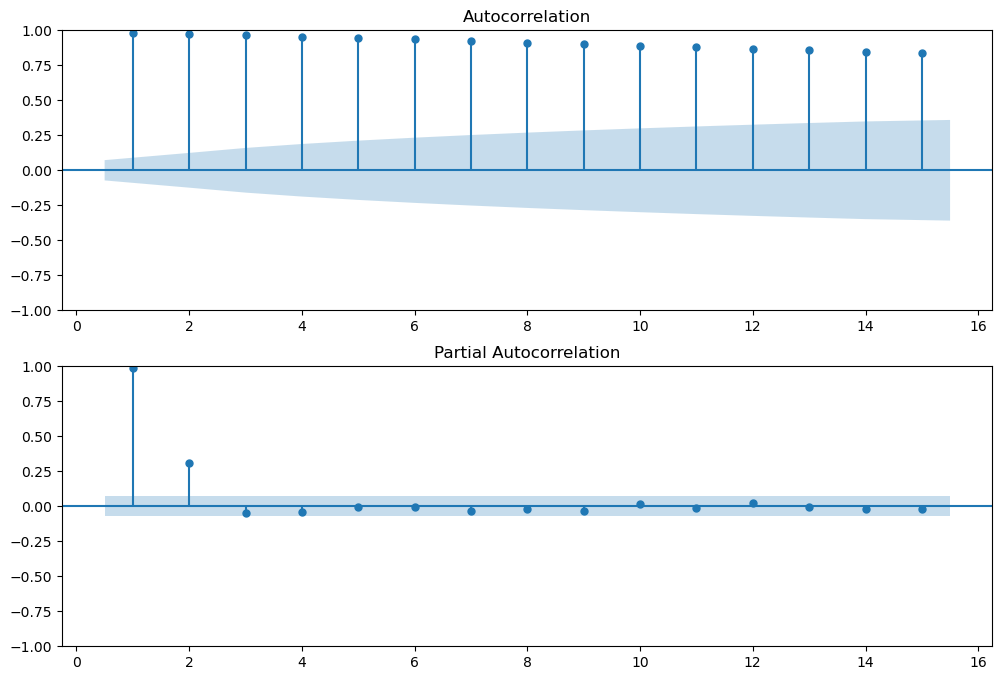

In [10]:
# Import acf and pacf libraries
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
# Plot the ACF of df
plot_acf(df['Revenue'], lags=15, zero=False, ax=ax1)


# Plot the PACF of df
plot_pacf(df['Revenue'], lags=15, zero=False, ax=ax2)


plt.show()

In [11]:
#adjust yearly revenue using differencing
dfsa=df['Revenue'].diff(2)

dfsa.head(10)

Day
2019-01-02         NaN
2019-01-03         NaN
2019-01-04    0.825542
2019-01-05    0.319539
2019-01-06    0.257012
2019-01-07   -0.212678
2019-01-08   -0.588653
2019-01-09    0.269045
2019-01-10   -0.189827
2019-01-11    0.215049
Name: Revenue, dtype: float64

In [12]:
#drop Nan values
dfsa2 = dfsa.dropna()
dfsa2

Day
2019-01-04    0.825542
2019-01-05    0.319539
2019-01-06    0.257012
2019-01-07   -0.212678
2019-01-08   -0.588653
                ...   
2020-12-28   -0.527497
2020-12-29    0.729388
2020-12-30   -0.127921
2020-12-31   -1.295853
2021-01-01   -0.182839
Name: Revenue, Length: 729, dtype: float64

/Users/draihome/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


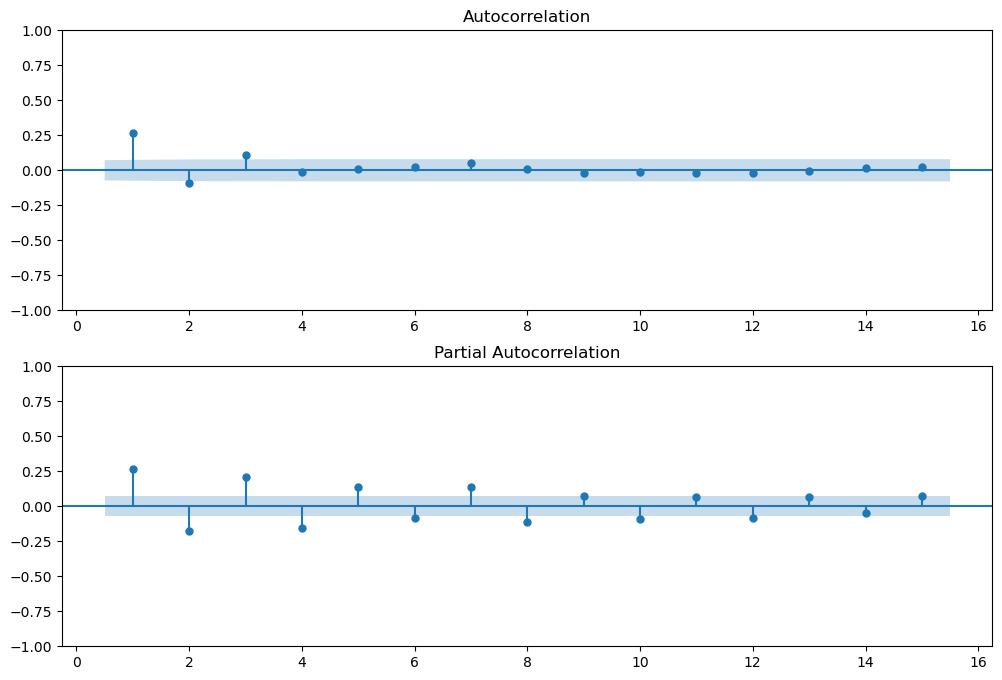

In [13]:
# Create figure for adjusted revenue
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
# Plot the ACF of df
plot_acf(dfsa2, lags=15, zero=False, ax=ax1)


# Plot the PACF of df
plot_pacf(dfsa2, lags=15, zero=False, ax=ax2)


plt.show()

In [14]:
#import train_test_split module
from sklearn.model_selection import train_test_split

train = df.loc[:'2020-08-08']
test = df.loc['2020-08-09':]


print(train.shape, test.shape)


(585, 1) (146, 1)


In [15]:
#save the cleaned dataset and train/test split files
dfsa2.to_csv('clean.csv')
train.to_csv('train.csv')
test.to_csv('test.csv')

### The Decomposed Time Series

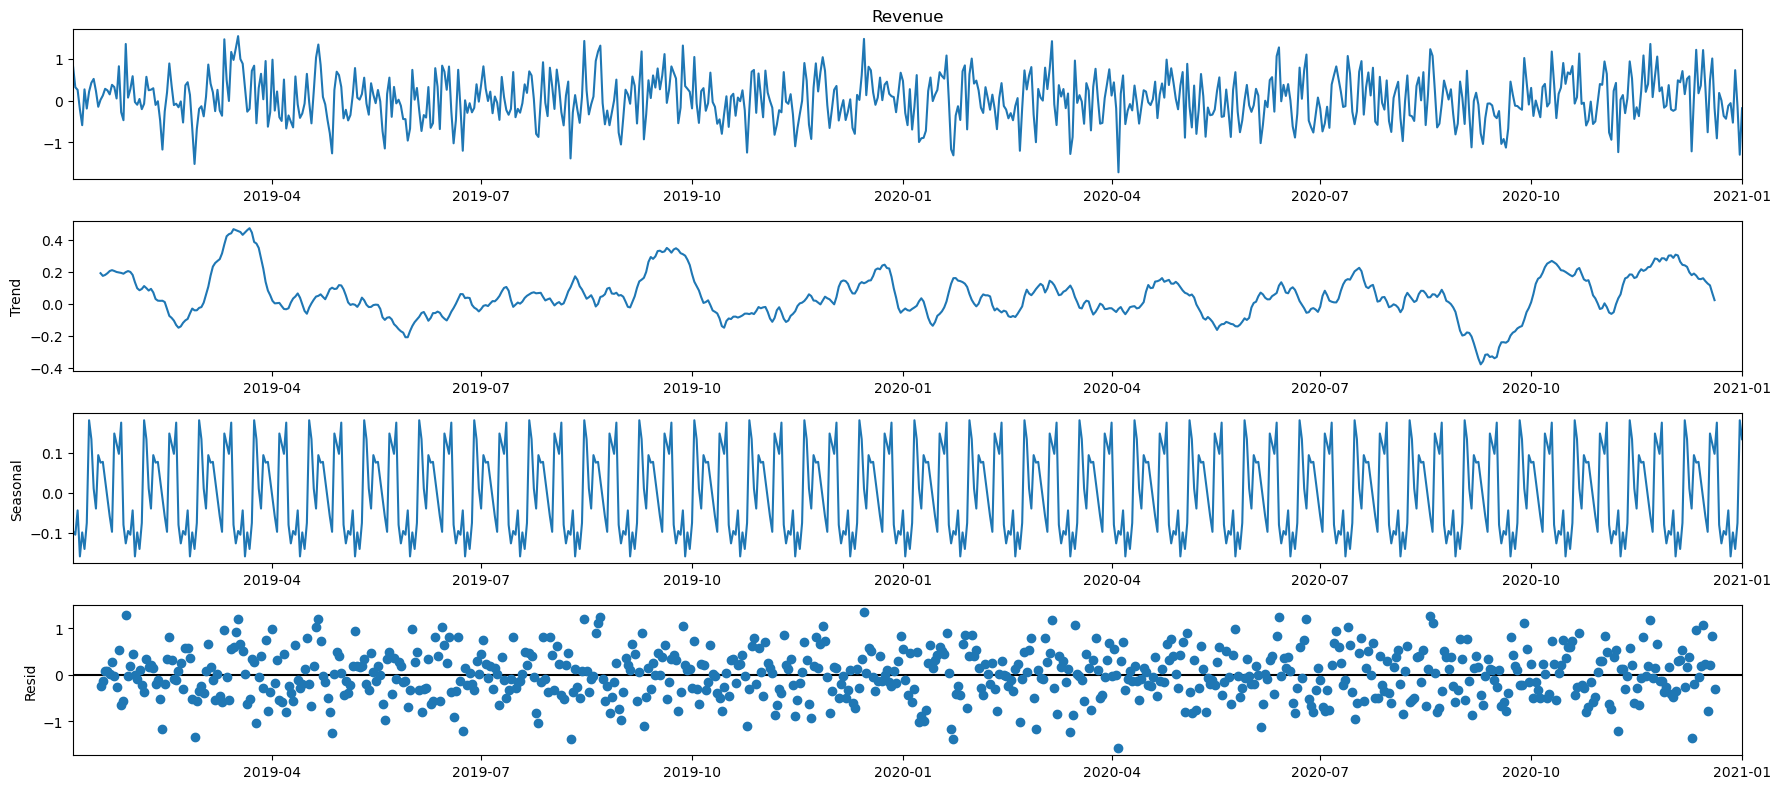

In [16]:
rcParams['figure.figsize'] = 18, 8
# Perform decompositon 

#res = sm.tsa.seasonal_decompose(y,period=24, model='additive')

res = sm.tsa.seasonal_decompose(dfsa2,period=24, model='additive')

# Plot the result
res.plot()

# Show the plot
plt.show()

### Spectral Density

Spectral density is used to show autocovariance time frequencies. Autocovariance is
the covariance between elements. 


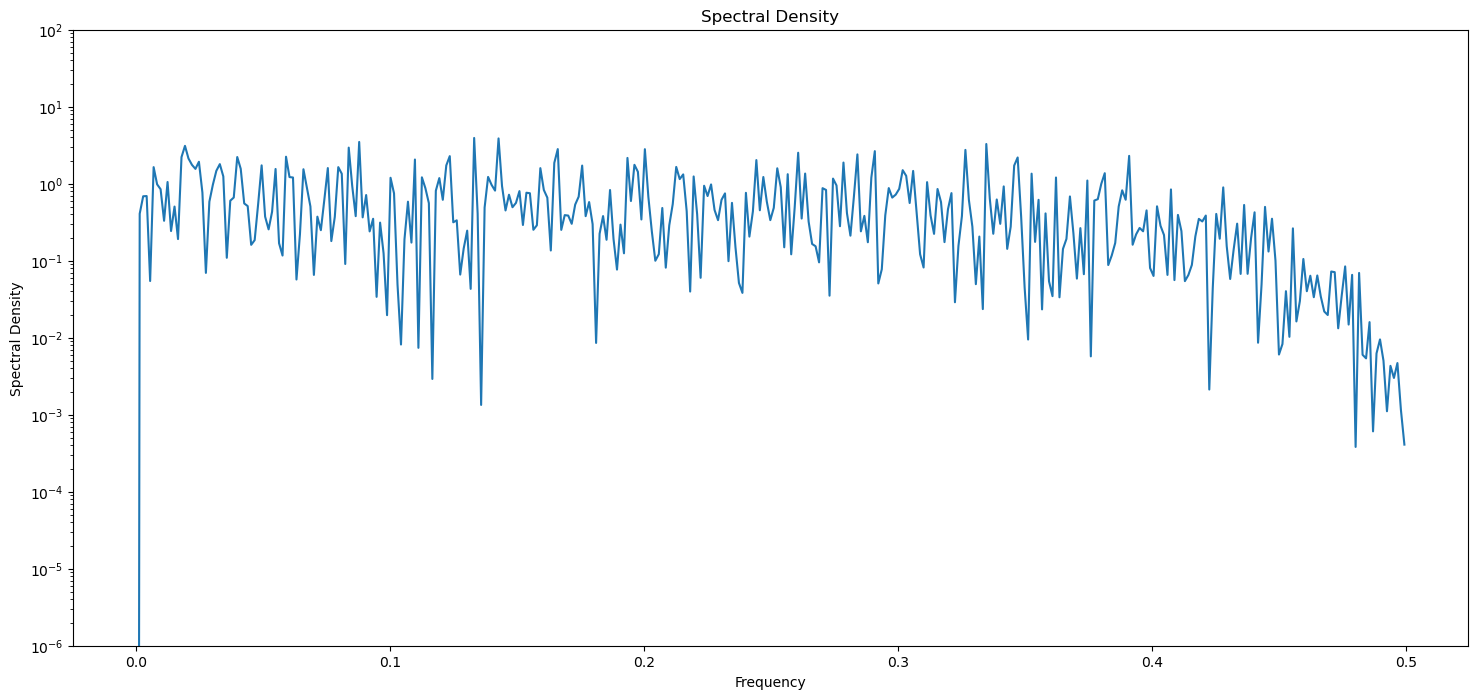

In [17]:
#spectral density visualization
from scipy import signal
rng = np.random.default_rng()

f,Pxx_den = signal.periodogram(dfsa2)
plt.semilogy(f, Pxx_den)
plt.ylim([1e-6, 1e2])
plt.title('Spectral Density')
plt.xlabel('Frequency')
plt.ylabel('Spectral Density')
plt.show()

### Residuals

Based on the histogram, the residuals seem almost normally distributed. There isn’t a
lack of trends in the residuals in the decomposed series.


<AxesSubplot:title={'center':'Residuals'}, xlabel='Day'>

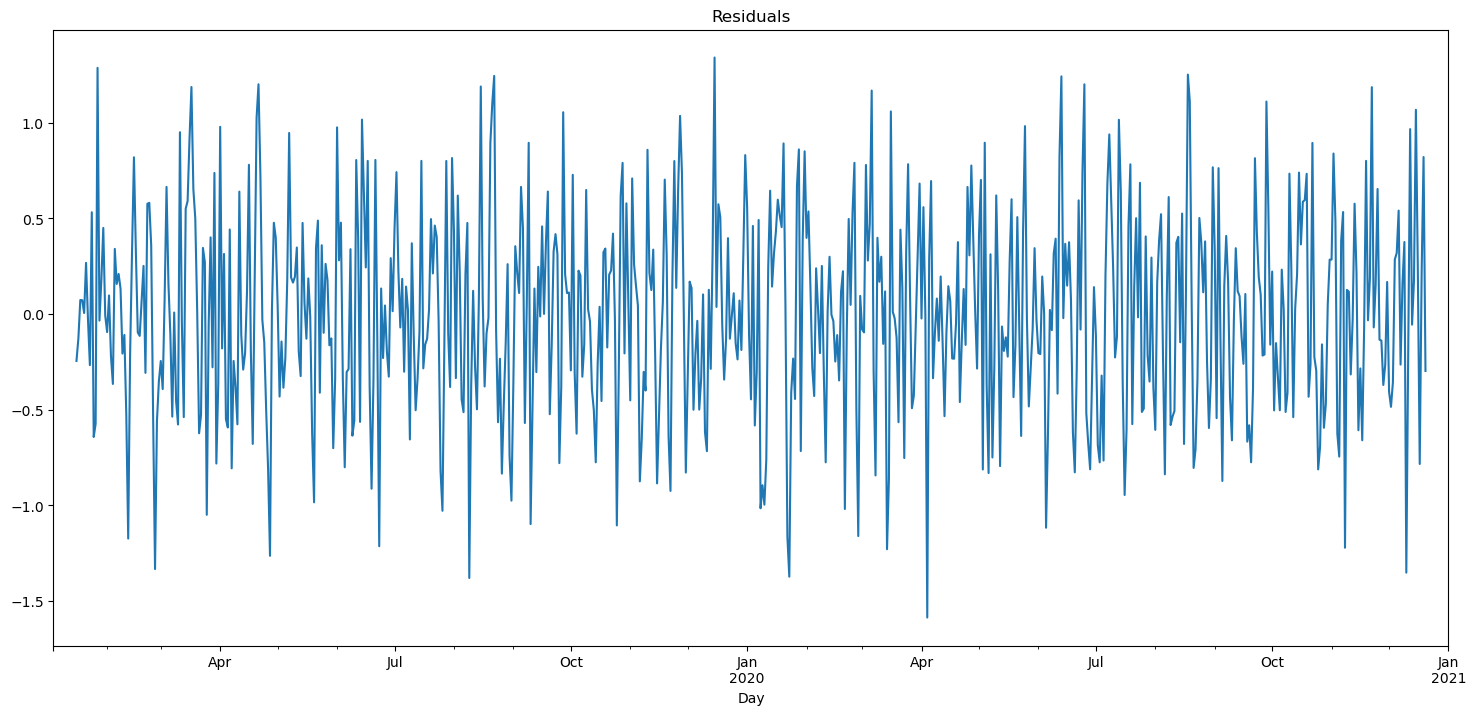

In [18]:
#plot residual
plt.title('Residuals')
res.resid.plot()

### Seasonality

The time series dataset showed a presence of a seasonal component. It was observed that cycles were repeating over time. These cycles took place at the same frequency.


<AxesSubplot:title={'center':'Seasonality'}, xlabel='Day'>

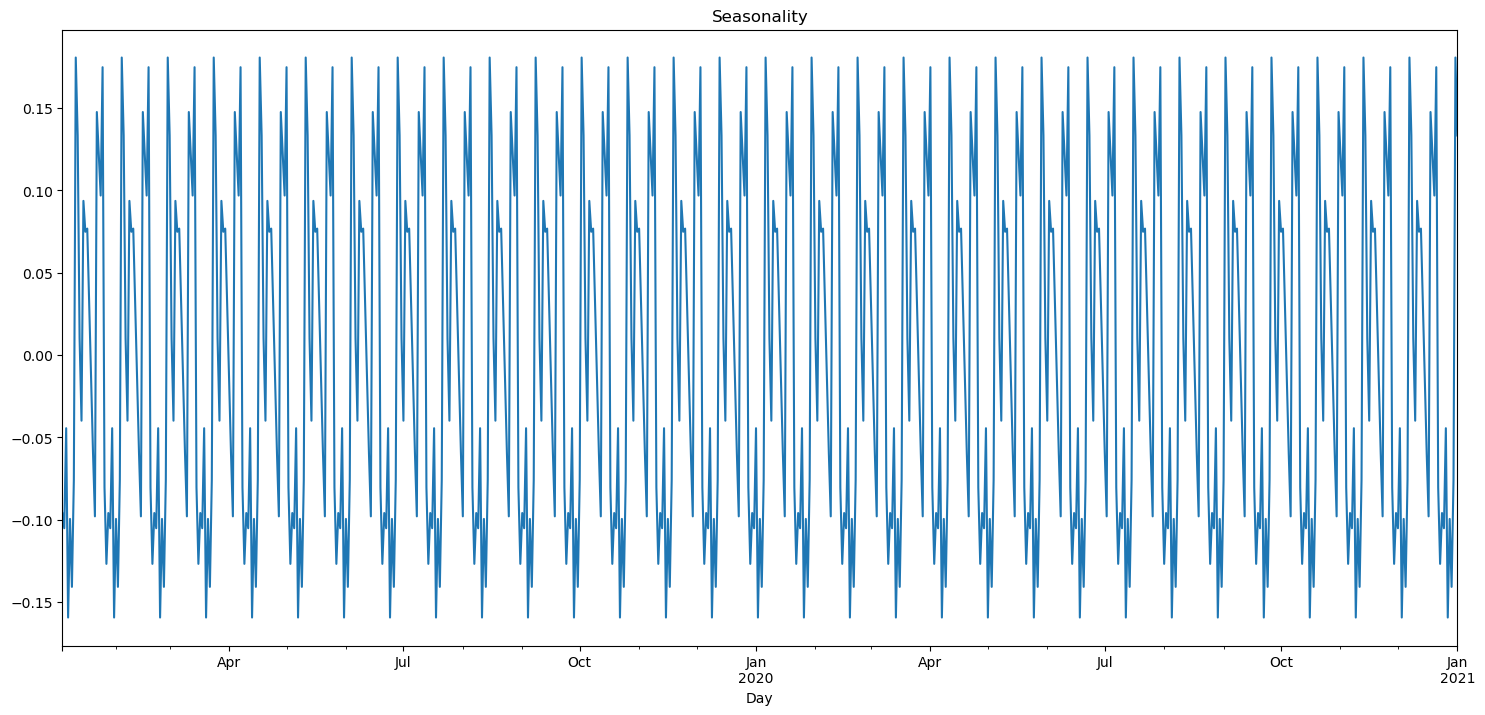

In [19]:
#plot residual
plt.title('Seasonality')
plt.xlabel('Days')
res.seasonal.plot()

<AxesSubplot:title={'center':'Residuals'}>

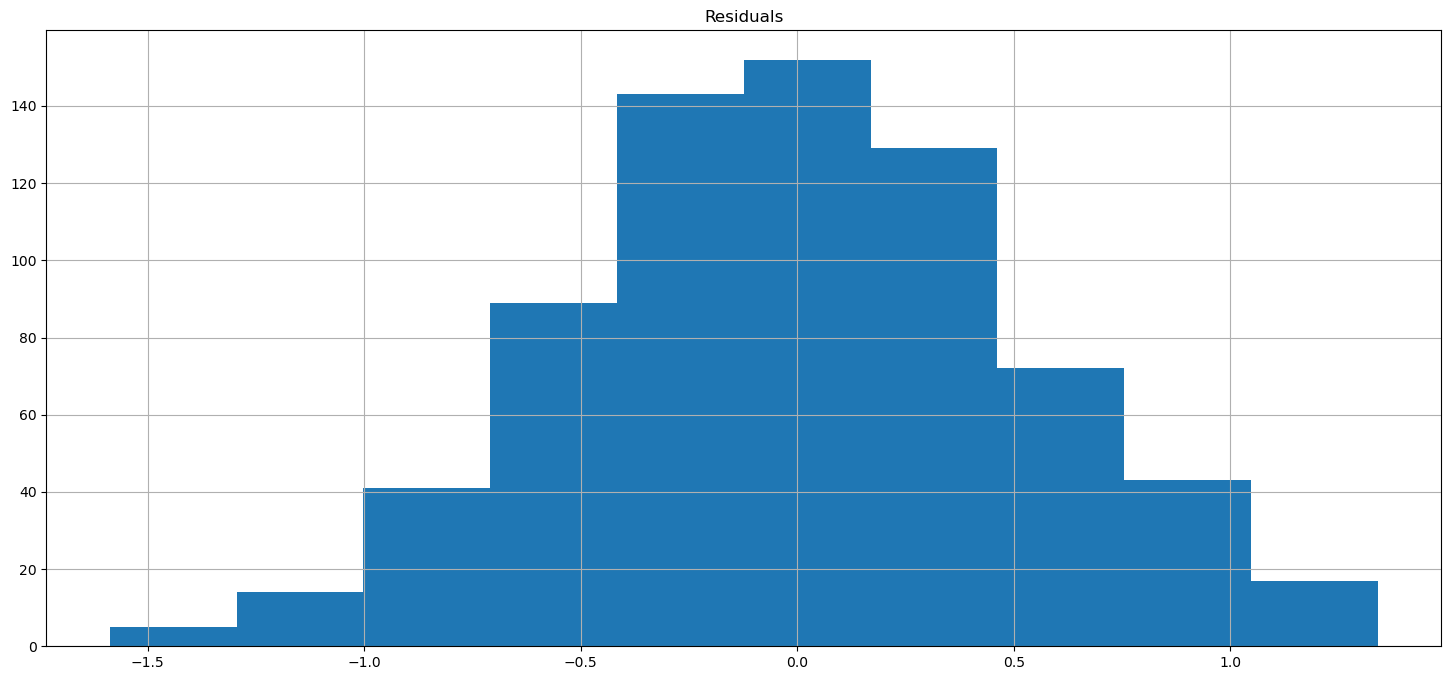

In [20]:
#plot residual histogram
plt.title('Residuals')
res.resid.hist()

### Trends

The visualization for Trend shows that the time series data has no trend.

<AxesSubplot:title={'center':'Trend'}, xlabel='Day'>

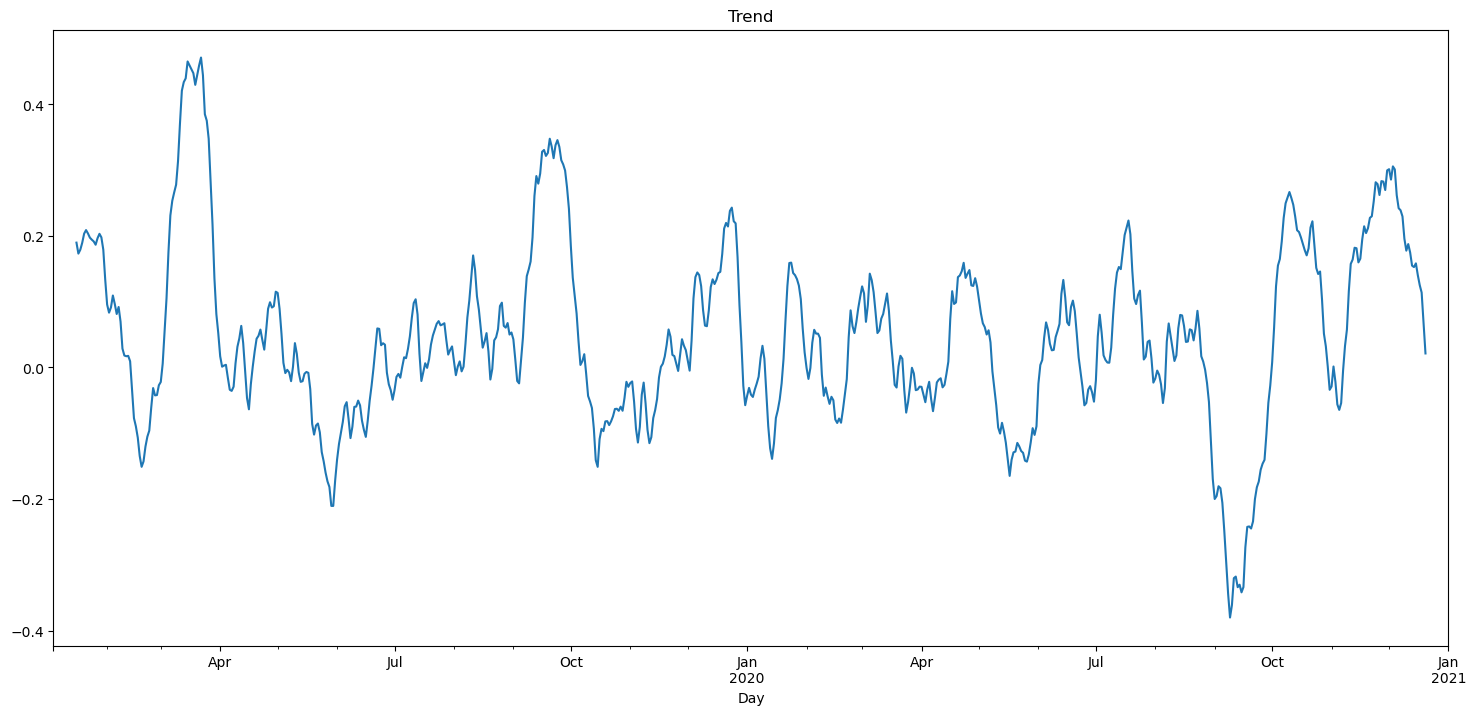

In [21]:
#plot trend
plt.title('Trend')
plt.xlabel('Days')
res.trend.plot()

## ARIMA MODEL

The Auto ARIMA module was also executed in conjunction with the ACP and PACF plots to find the p, d,q. The p = the order of autoregressive part, d = degree of differencing, q = the order of moving average. The goal was to find the model with the lowest Akaike Information Criterion (AIC). The summary showed that ARIMA(1,1,0) had the lowest. The AIC value was 774.90. The Ljung-Box had a p-value of 0. I then created other ARIMA models manually but could not get a lower AIC value. Therefore, I continued to use this model for the analysis.

In [22]:
#run auto arima model to find model with lowest AIC
import warnings
warnings.filterwarnings("ignore")
auto_fit=auto_arima(df, trace=True, suppress_warnings=True)
auto_fit.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=987.305, Time=0.89 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1162.819, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=983.122, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1019.369, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1162.139, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=985.104, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=985.106, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=986.045, Time=0.56 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=984.710, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 2.100 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  731
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -488.561
Date:                Tue, 03 Jan 2023   AIC                            983.122
Time:                        23:52:27   BIC                            996.901
Sample:                             0   HQIC                           988.438
                                - 731                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0332      0.018      1.895      0.058      -0.001       0.068
ar.L1         -0.4692      0.033    -14.296      0.000      -0.534      -0.405
sigma2         0.2232      0.013     17.801      0.000       0.199       0.248
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.05
Prob(Q):                              0.96   Prob(JB):                         0.36
Heteroskedasticity (H):               1.02   Skew:                            -0.02
Prob(H) (two-sided):                  0.85   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### The model evaluation procedure and error metric:
To evaluate the model, we used auto ARIMA to provide the ARIMA model with best AIC for our data, and then fitted the model to the data. I also looked at the model diagnostics by running the. plot_diagnostics() method. The first visualization showed residuals having no pattern. This was the goal. The next was a histogram. The aim was to have both lines identical and having a normal distribution. This was achieved. The normal QQ plot showed that the residuals were normally distributed, as they were on the red line. The last visualization is the correlogram. It is an ACF plot of the residual. It showed that 95% of the correlations for lags greater than zero, were not significant. 


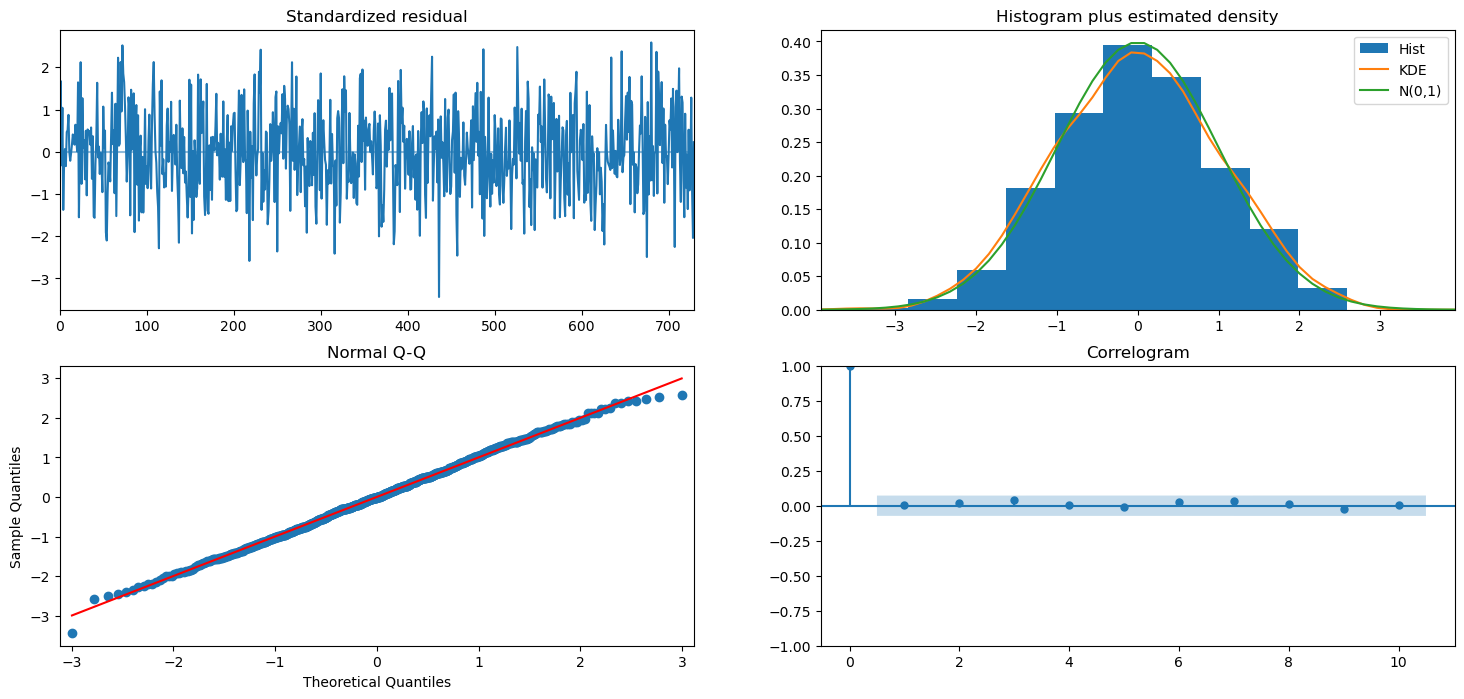

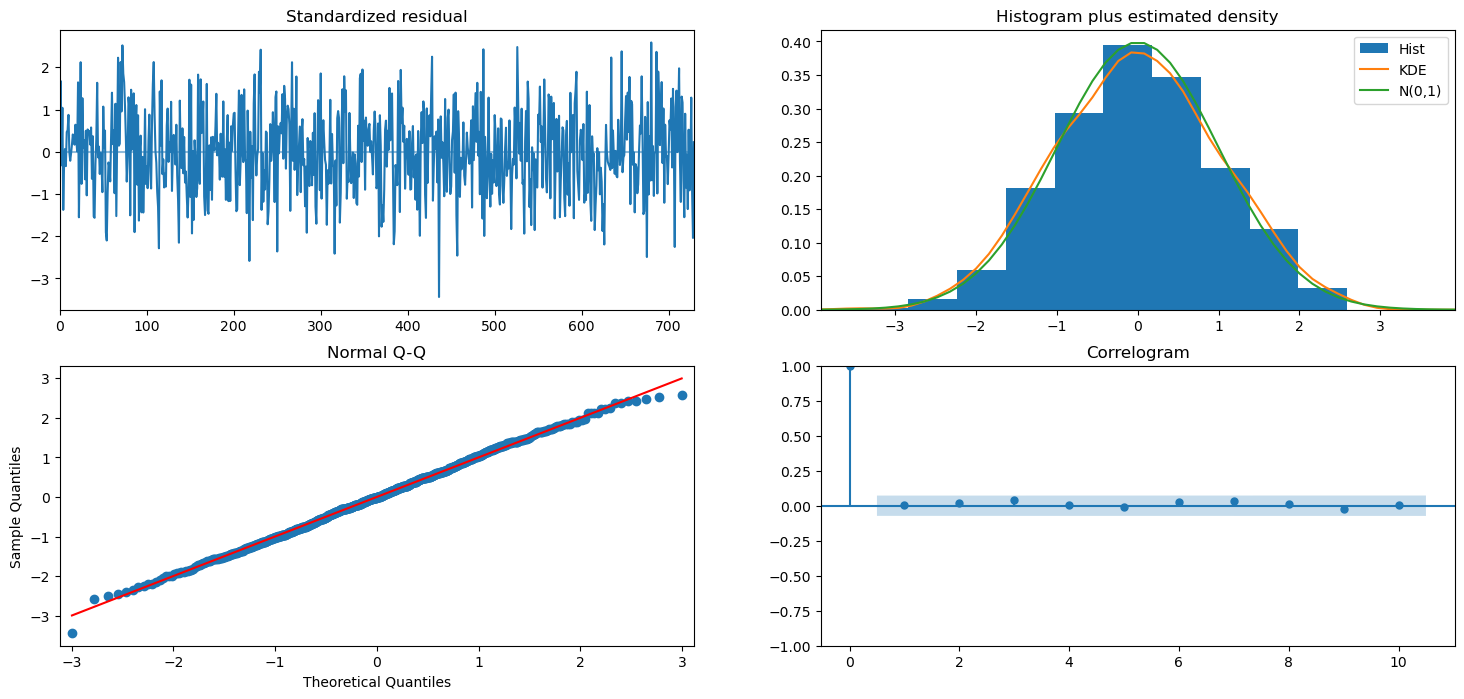

In [23]:
#plot diagonistics
auto_fit.plot_diagnostics()

In [24]:
#fit the train data to an ARMA(1,1,1) model manually
mod10 = ARIMA(df, order=(1,1,0))
result10 =  mod10.fit()
result10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  731
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -490.355
Date:                Tue, 03 Jan 2023   AIC                            984.710
Time:                        23:52:29   BIC                            993.896
Sample:                    01-02-2019   HQIC                           988.254
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4667      0.033    -14.213      0.000      -0.531      -0.402
sigma2         0.2243      0.013     17.782      0.000       0.200       0.249
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.07
Prob(Q):                              0.98   Prob(JB):                         0.36
Heteroskedasticity (H):               1.02   Skew:                            -0.02
Prob(H) (two-sided):                  0.89   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(result10.resid))

# Print mean absolute error
print(mae)

# Make plot of time series for comparison
df.plot()
plt.show()

The mean absolute error was used as an error metric. The MAE result was 0.3805008714366282. This meant that the mean error was 0.381 of a million per year. Seeing that the average was almost 10 million a year. That error metric was very low. 

In [26]:
# Generate in-sample predictions
pred = result10.get_prediction(start=585, end=730, typ='levels')

# Extract prediction mean
mean_pred = pred.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = pred.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower Revenue']
upper_limits = confidence_intervals.loc[:,'upper Revenue']

# Print best estimate predictions
print(mean_pred)

2020-08-09    13.600856
2020-08-10    13.401128
2020-08-11    13.236845
2020-08-12    12.966449
2020-08-13    13.196309
                ...    
2020-12-28    17.086900
2020-12-29    16.852096
2020-12-30    17.229756
2020-12-31    17.124243
2021-01-01    16.478925
Freq: D, Name: predicted_mean, Length: 146, dtype: float64


## FORECASTING USING ARIMA MODEL

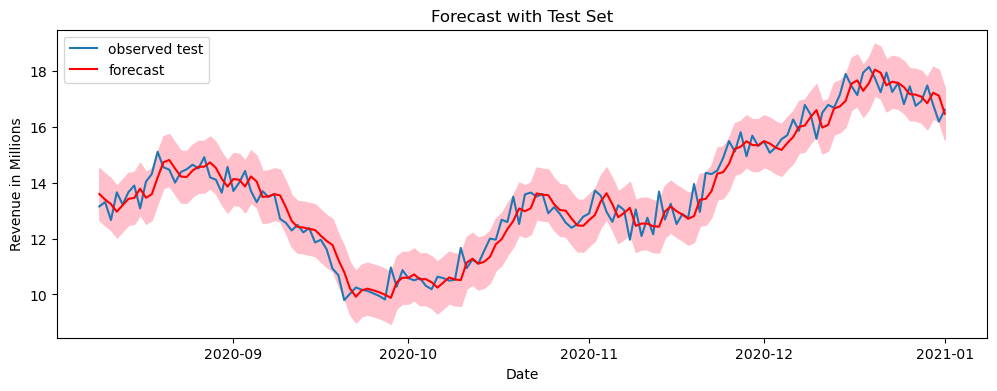

In [27]:
#plot the data
plt.figure(figsize=(12,4))
plt.plot(test.index, test,label='observed test')

#plot predictions
plt.plot(mean_pred.index, mean_pred, color='r', label='forecast')

#shade area between confidence limits
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color = 'pink')

#plot graph's title, labes and legend
plt.title('Forecast with Test Set')
plt.xlabel('Date')
plt.ylabel('Revenue in Millions')
plt.legend()
plt.show()

In [28]:
#print forecast results
forecast_R = result10.get_forecast()

test_VR = test['Revenue'].values.astype('float32')
forecast_test = forecast_R.predicted_mean
print('Expected : %.2f' % forecast_test)
print('Forecasted : %.2f' % test_VR[0])
print('Standard Error : %.2f' % forecast_R.se_mean)

Expected : 16.42
Forecasted : 13.15
Standard Error : 0.47


In [29]:
# Generate predictions
pred2 = result10.get_forecast(steps=60)

# Extract prediction mean
mean_pred2 = pred2.predicted_mean

# Get confidence intervals of predictions
confidence_intervals2 = pred2.conf_int()

# Select lower and upper confidence limits
lower_limits2 = confidence_intervals2.loc[:,'lower Revenue']
upper_limits2 = confidence_intervals2.loc[:,'upper Revenue']

# Print best estimate predictions
mean_pred2.head()

2021-01-02    16.422010
2021-01-03    16.514776
2021-01-04    16.471486
2021-01-05    16.491688
2021-01-06    16.482261
Freq: D, Name: predicted_mean, dtype: float64

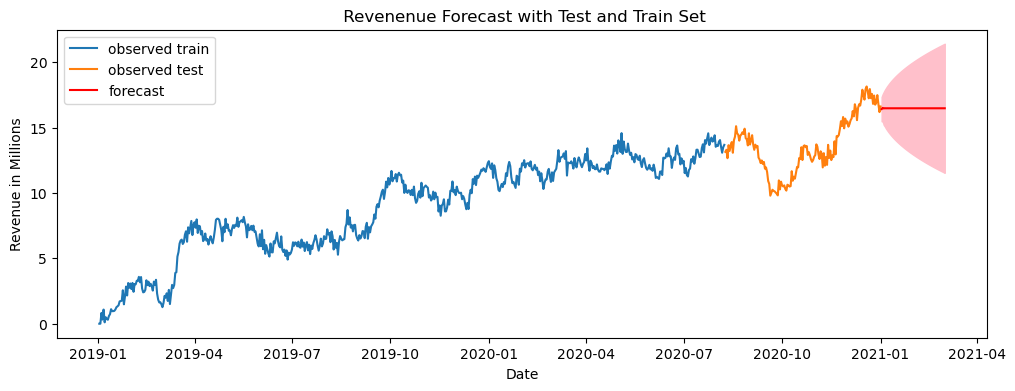

In [30]:
#plot the data
plt.figure(figsize=(12,4))
plt.plot(train.index, train,label='observed train')

plt.plot(test.index, test,label='observed test')


#plot predictions
plt.plot(mean_pred2.index, mean_pred2, color='r', label='forecast')

#shade area between confidence limits
plt.fill_between(lower_limits2.index, lower_limits2, upper_limits2, color = 'pink')

#plot graph's title, labes and legend
plt.title(' Revenenue Forecast with Test and Train Set')
plt.xlabel('Date')
plt.ylabel('Revenue in Millions')
plt.legend()
plt.show()

## RECOMMENDATIONS

The time series model had a good performance. We have forecasted revenue for the next 60 days based on the previous two years of data. The company can use this for forecasts less than a year. This can be used to know the short-term impact, customers churned or not churned, would have on their future revenue. With this, stakeholders can develop a strategy to improve customer retention and increase revenue. 
